In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn


import torchvision
import torchvision.transforms as transforms

from torchsummary import summary
from torch.autograd import Variable

from extra.utils import *
from extra.customdataset import *

In [2]:
batch_size = 256
torch.manual_seed(1337)

In [3]:
classes = { 'cloudy':0 , 'rain':1 , 'shine':2, 'sunrise': 3}

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(csv_file = '/data/weather-dataset/train_labels.csv',
                              img_folder_dir = '/data/weather-dataset/train_set',
                              shape=(64,64),
                              mapping_dict=classes,
                              transform = transform_train)

test_dataset = CustomDataset(csv_file = '/data/weather-dataset/test_labels.csv',
                             img_folder_dir = '/data/weather-dataset/test_set',
                             shape=(64,64),
                             mapping_dict=classes,
                             transform = transform_test)

trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


In [4]:
images, labels = iter(trainloader).next()

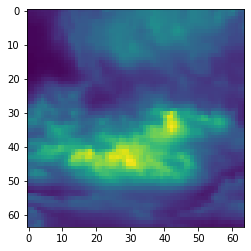

In [5]:
plt.imshow(images[0][0].numpy().squeeze())

In [6]:
from models.custom.weather import *

In [7]:
model = Weather()

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    model = model.cuda()
    cudnn.benchmark = True
torch.cuda.is_available()

True

In [9]:
summary(model, (3, 64, 64), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [256, 16, 64, 64]             448
       BatchNorm2d-2          [256, 16, 64, 64]              32
              ReLU-3          [256, 16, 64, 64]               0
         MaxPool2d-4          [256, 16, 32, 32]               0
            Conv2d-5          [256, 32, 32, 32]           4,640
       BatchNorm2d-6          [256, 32, 32, 32]              64
              ReLU-7          [256, 32, 32, 32]               0
         MaxPool2d-8          [256, 32, 16, 16]               0
            Linear-9                   [256, 4]          32,772
Total params: 37,956
Trainable params: 37,956
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 12.00
Forward/backward pass size (MB): 624.01
Params size (MB): 0.14
Estimated Total Size (MB): 636.15
----------------------------------------

In [10]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001,
                      momentum=0.9, weight_decay=5e-4)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [11]:
train_losses, train_accuracies = [], []
def train_nn(epoch):
    model.train()
    with tqdm(trainloader, unit="batch") as tepoch:
        for data, target in tepoch:
            tepoch.set_description(f"Train epoch {epoch}")
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            _, predictions = output.max(1)
            loss = criterion(output, target)
            correct = predictions.eq(target).sum().item()
            accuracy = (predictions == target).float().mean()
            
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            train_accuracies.append(accuracy.item())

            tepoch.set_postfix(loss=loss.item(), accuracy=100. * accuracy.item())

In [12]:
test_losses, test_accuracies = [], []
def test_nn(epoch):
    model.eval()
    with torch.no_grad():
        with tqdm(testloader, unit="batch") as tepoch:
            for data, target in tepoch:
                tepoch.set_description(f"Test epoch {epoch}")
                
                data, target = data.to(device), target.to(device)
                output = model(data)
                _, predictions = output.max(1)
                loss = criterion(output, target)
                correct = predictions.eq(target).sum().item()
                accuracy = (predictions == target).float().mean()
                
                test_losses.append(loss.item())
                test_accuracies.append(accuracy.item())

                tepoch.set_postfix(loss=loss.item(), accuracy=100. * accuracy.item())

In [13]:
for epoch in trange(0, 64):
    train_nn(epoch)
    test_nn(epoch)
    scheduler.step()

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

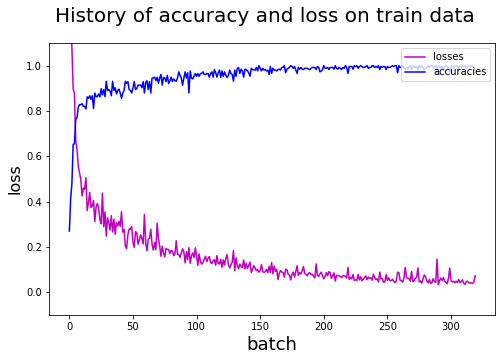

In [14]:
x = np.linspace(0, 15, num=15)

fig = plt.figure(figsize=(8, 5))
plt.plot(train_losses, color='m', label='losses')
plt.plot(train_accuracies, color='b', label='accuracies') 
plt.ylim(-0.1, 1.1)

fig.suptitle('History of accuracy and loss on train data', fontsize=20)
plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)
plt.legend(loc='upper right')

plt.show()

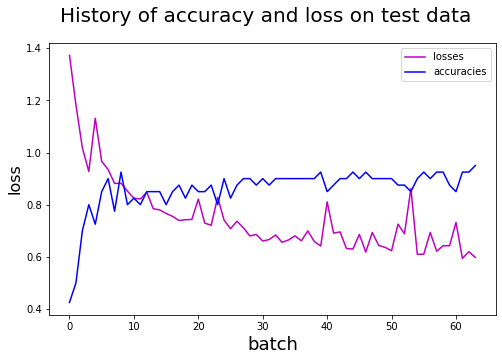

In [15]:
x = np.linspace(0, 15, num=15)

fig = plt.figure(figsize=(8, 5))
plt.plot(test_losses, color='m', label='losses')
plt.plot(test_accuracies, color='b', label='accuracies') 

fig.suptitle('History of accuracy and loss on test data', fontsize=20)
plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)
plt.legend(loc='upper right')

plt.show()

In [16]:
model.eval()
correct = 0
total = 0

for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    images = Variable(images)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print('Test accuracy all test images  = %f %%' % (100. * correct / total))

# Test accuracy all test images  = 92.500000 % - ADAM
# Test accuracy all test images  = 95.000000 % - SGD

Test accuracy all test images  = 95.000000 %


In [17]:
X_val, Y_val = next(iter(testloader))
Y_pred = model(X_val.to(device))
Y_pred = torch.argmax(Y_pred, 1)

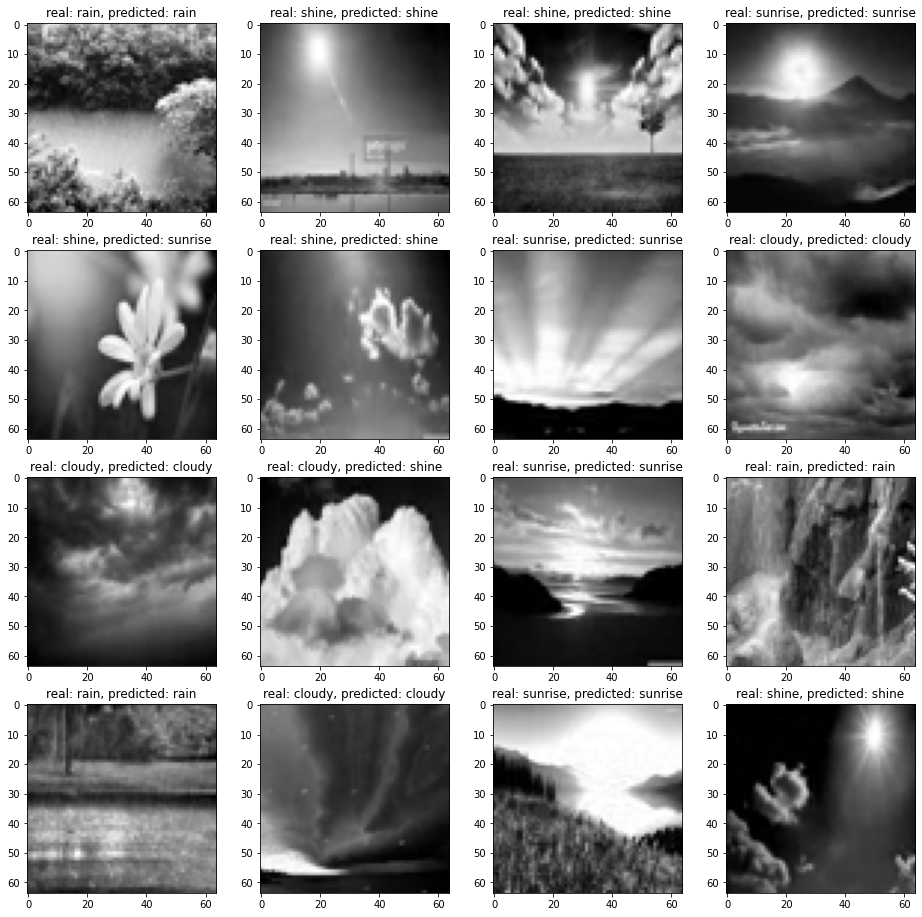

In [18]:
fig = plt.figure(figsize=(16, 16))
columns, rows = 4, 4
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_val[i][0].squeeze(), cmap='gray')
    plt.title('real: {}, predicted: {}'.format(get_key_by_value(classes, Y_val[i].item()),
                                               get_key_by_value(classes, Y_pred[i].item())))
plt.show()